Praktikum zu Vorlesung
[__Modellreduktion parametrisierter Systeme__](https://www.uni-muenster.de/AMM/Veranstaltungen/SS19/Modellreduktion/)

Mario Ohlberger, Felix Schindler, Tim Keil

# Blatt 07, 19.06.2019

* Aktivieren Sie wie gewohnt ihre Arbeitsumgebung und starten Sie den Jupyter Notebook server, siehe zB [Blatt 1, Aufgabe 0](https://www.uni-muenster.de/AMM/Veranstaltungen/SS19/Modellreduktion/blatt_01__aufgaben.html#Aufgabe-0:-jupyter-Notebook-Server-starten).

* Erstellen Sie ein neues `Python 3` Notebook oder laden Sie dieses von der Homepage herunter.

* Importieren Sie `numpy` und `pymor.basic` und machen Sie `matplotlib` für das Notebook nutzbar.

In [1]:
%matplotlib notebook
from pymor.basic import *
from problems import *
from algorithms import *
import time
from matplotlib import pyplot as plt
set_log_levels({'pymor': 'WARN',
                'pymor.functions.bitmap': 'CRITICAL'})

## Aufgabe 1: RB-Projektion

1. Schreiben Sie eine Funktion `solve_reduced(d, basis, mu)`, welche zu einer gegebenen Diskretisierung `d` und einer reduzierten Basis `basis` die RB-Approximation der Lösung zum Parameter `mu` bestimmt. Verwenden Sie dabei die `apply2`- und `apply_adjoint`- Methoden von `d.operator`und `d.rhs`, um das reduzierte Problem zu assemblieren.

Um die reduzierte Systemmatrix und die reduzierte rechte Seite zu assemblieren, müssen wir `d.operator` sowie `d.rhs` auf den Vektoren der gegebenen reduzierten Basis auswerten. `d.operator` fassen wir dabei als Bilinearform auf, die wir wie gewohnt mittels `apply2` auswerten. Für das Rechte-Seite-Funktional verwenden wir die `apply_adjoint`-Methode, welche ein neues `VectorArray` mit den Operatorauswertungen zurückliefert. Dabei haben Funktionale in pyMOR grundsätzlich als `source` den Raum `NumpyVectorSpace(1)`. Mit `d.rhs.apply_adjoint(basis).data` erhalten wir also den reduzierten Rechte-Seite-Vektor als ein `len(basis) x 1` NumPy-Array.

Außerdem ist zu beachten, dass `d.operator` und `d.rhs` parametrisch sein können, weshalb wir `apply_adjoint` bzw. `apply2` zusätzlich den Parameter `mu` übergeben müssen:

In [2]:
def solve_reduced(d, basis, mu):
    lhs = d.operator.apply2(basis, basis, mu=mu)
    rhs = d.rhs.apply_adjoint(basis, mu=mu)
    u = np.linalg.solve(lhs, rhs.data)
    U = basis.lincomb(u.ravel())
    return U

2. Schreiben Sie eine Funktion `build_basis(d, N)`, um zu einer Diskretisierung `d` eine reduzierte Basis der Größe `N` aus `2*N` zufälligen Lösungssnapshots zu berechnen. Verwenden Sie die Methode `greedy_approximation` von Blatt 6.

In [3]:
def build_basis(d, N):
    snapshots = d.solution_space.empty()
    for mu in d.parameter_space.sample_randomly(2*N):
        print('.', end='')
        snapshots.append(d.solve(mu))
    basis, _ = greedy_approximation(snapshots, N, product=d.h1_0_semi_product, orthogonalize=True)
    return basis

3. Diskretisieren Sie das parametrische Problem von Blatt 4 Aufgabe 1 und berechnen Sie mittels `solve_reduced` reduzierte Lösungen für verschiedene Basisgrößen (mit oder ohne Greedy-Verfahren), und visualisieren Sie die reduzierte Lösung zusammen mit der hochdimensionalen Lösung sowie der Differenz der beiden Lösungen.

In [4]:
timings = {}

t = time.time()
d, _ = discretize_stationary_cg(problem_B4_A1_parametric())
timings['discretize'] = time.time() - t

t = time.time()
basis = build_basis(d, 30)
timings['basis'] = time.time() - t

............................................................

Wir berechnen für einen zufälligen Parameter die reduzierten Lösungen für verschiedene Größen der reduzierten Basis:

In [5]:
mu = d.parameter_space.sample_randomly(1, seed=5678)[0]

Us = d.solution_space.empty()
U_rbs = d.solution_space.empty()
U = d.solve(mu)
for N in range(len(basis) + 1):
    Us.append(U)
    U_rbs.append(solve_reduced(d, basis[:N], mu))

`d.visualize` hat neben `separate_colorbars` zusätzlich den Parameter `rescale_colorbars`, der eine Reskalierung der Colorbar mit jedem Zeitschritt erzwingt:

<IPython.core.display.Javascript object>


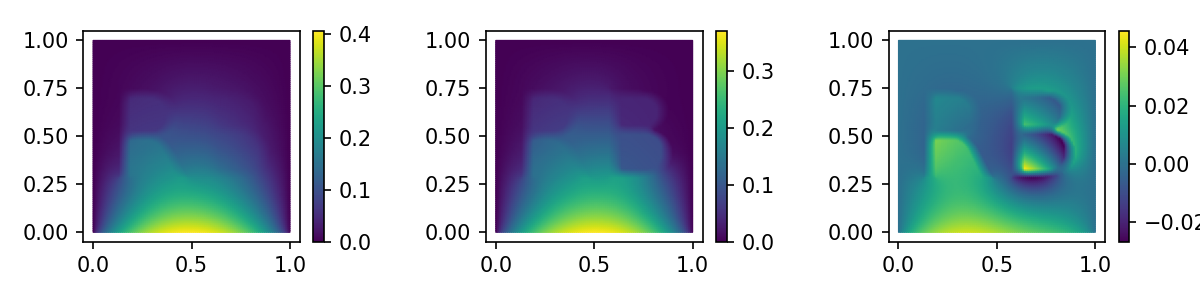

interactive(children=(IntSlider(value=0, description='t', max=30), Output()), _dom_classes=('widget-interact',…

In [6]:
import matplotlib as mpl
figsize = mpl.rcParams['figure.figsize']
mpl.rcParams['figure.figsize'] = (8.0, 2.0)

d.visualize((Us, U_rbs, Us - U_rbs), 
            separate_colorbars=True, rescale_colorbars=True, columns=3)

mpl.rcParams['figure.figsize'] = figsize

4. Bestimmen Sie empirisch den maximalen Modellreduktionsfehler aus 100 Parametern und plotten Sie diesen zusammen mit dem maximalen Fehler der orthogonalen Projektion auf den RB-Raum in Abhängigkeit von der Basisgröße.

Da die diskreten Lösungsvektoren des hochdimensionalen Problems für die gewählte Auflösung noch vergleichsweise klein sind, können wir es uns erlauben, diese für alle Test-Parameter im Speicher vorzuhalten, was wir durch caching der Diskretisierung erreichen:

In [7]:
d.enable_caching('disk')

Daher messen wir jetzt einmal die nötige Zeit um Lösungen zu bestimmen

In [8]:
test_mus = d.parameter_space.sample_randomly(100, seed=5678)

timings['fom'] = list()
for mu in test_mus:
    print('.', end='')
    t = time.time()
    d.solve(mu)
    timings['fom'].append(time.time() - t)

print()
print('took {}s (on average {}s)'.format(np.sum(timings['fom']), np.sum(timings['fom'])/len(test_mus)))

....................................................................................................
took 15.26306414604187s (on average 0.15263064146041871s)


In [9]:
# check caching: solve for the same mus
t = time.time()
for mu in test_mus:
    print('.', end='')
    d.solve(mu)
print()
print('took {}s'.format(time.time() - t))

....................................................................................................
took 0.07886123657226562s


Neben den maximalen Fehlern für orthogonale Projektion und reduzierte Lösung berechnen wir zusätzlich noch den minimalen Quotienten zwischen beiden Fehlern als Maß für den Verlust an Genauigkeit, wenn die Bestapproximation im reduzierten Raum (mittels orthogonaler Projektion) durch die Galerkin-Projektion ersetzt wird.

In [10]:
errors = list()
proj_errors = list()
efficiencies = list()
for N in range(len(basis) + 1):
    print('.', end='', flush=True)
    size_N_errs = list()
    size_N_proj_errs = list()
    size_N_efficiencies = list()
    for mu in test_mus:
        U = d.solve(mu)
        U_rb = solve_reduced(d, basis[:N], mu)
        U_proj = orthogonal_projection(U, basis[:N], product=d.h1_0_semi_product)
        size_N_errs.append(d.h1_0_semi_norm(U - U_rb))
        size_N_proj_errs.append(d.h1_0_semi_norm(U - U_proj))
        size_N_efficiencies.append(size_N_proj_errs[-1] / size_N_errs[-1])
    errors.append(np.max(size_N_errs))
    proj_errors.append(np.max(size_N_proj_errs))
    efficiencies.append(np.min(size_N_efficiencies))

...............................

Und plotten diese, die Fehler wieder logarithmisch.

<IPython.core.display.Javascript object>


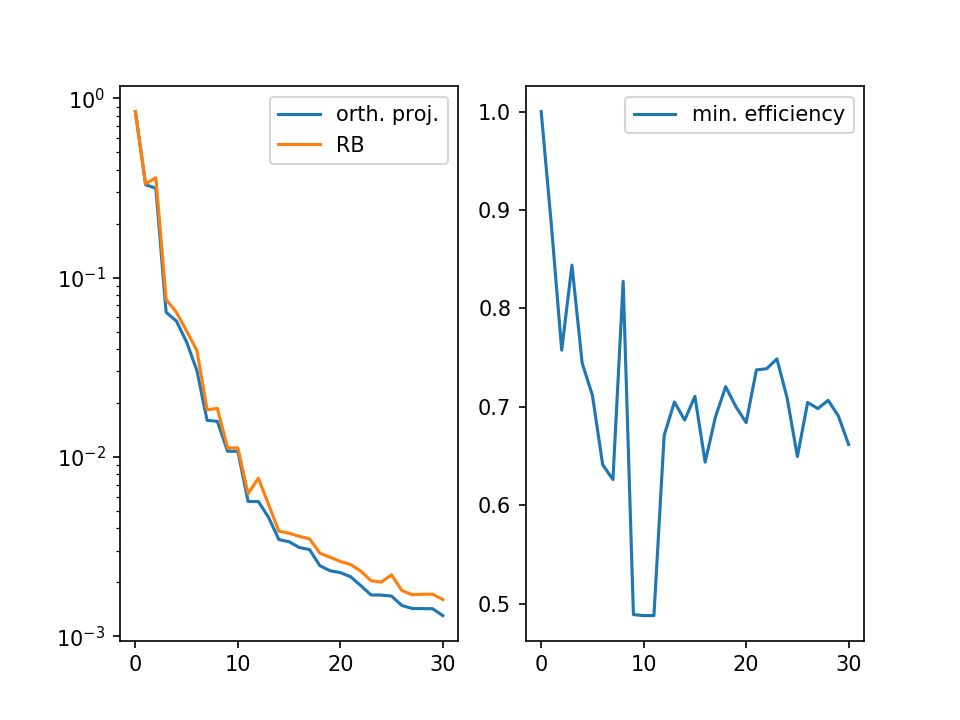

In [11]:
plt.figure()
plt.subplot(1, 2, 1)
plt.semilogy(np.arange(len(basis) + 1), proj_errors, label='orth. proj.')
plt.semilogy(np.arange(len(basis) + 1), errors, label='RB')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(efficiencies, label='min. efficiency')
plt.legend()

## Aufgabe 2: Offline-Online-Zerlegung

pyMOR's `project`-Methode ermöglicht die Reduzierte-Basis-Projektion von beliebigen pyMOR-Operatoren. Hierfür muss `project` lediglich der zu projizierende Operator sowie reduzierte Basen für den `range`- und `source`-`VectorSpace` des Operators übergeben werden. Als Ergebnis erhält man reduzierte pyMOR-Operatoren, welche die entsprechenden reduzierten Systemmatrizen enthalten.

Affine Zerlegungen, die im analytischen Problem mittels einer `LincombFunction` dargestellt wurden, werden von `discretize_stationary_cg` / `discretize_stationary_fv` automatisch in affine Zerlegungen der zugehörigen diskreten Operatoren überführt. Diese werden analog zur `LincombFunction` durch einen `LincombOperator` dargestellt:

In [12]:
print(d.operator.source)
print(d.operator.range)
print(type(d.operator))
print(len(d.operator.operators))
print(d.operator.operators)
print(d.operator.coefficients)

NumpyVectorSpace(20201, STATE)
NumpyVectorSpace(20201, STATE)
<class 'pymor.operators.constructions.LincombOperator'>
4
(<pymor.operators.numpy.NumpyMatrixOperator object at 0x7f6684a2cda0>, <pymor.operators.numpy.NumpyMatrixOperator object at 0x7f6684a2cd68>, <pymor.operators.numpy.NumpyMatrixOperator object at 0x7f66849c5c18>, <pymor.operators.numpy.NumpyMatrixOperator object at 0x7f66849c5da0>)
(1.0, 1.0, ExpressionParameterFunctional(-(1 - R), ParameterType({'R': ()})), ExpressionParameterFunctional(-(1 - B), ParameterType({'B': ()})))


Die project-Methode berücksichtigt automatisch solche affinen Operator-Zerlegungen und assembliert einen reduzierten LincombOperator, indem (rekursiv) die einzelnen Operatoren in d.operator.operators projiziert werden.

1. Benutzen Sie `pymor.algorithms.projection.project`, um für das parametrische Problem von Blatt 4 Aufgabe 1 einen RB-projizierten, affin-zerlegten Systemoperator und ein RB-projiziertes Rechte-Seite-Funktional zu erhalten. Wiederholen Sie hiermit die Experimente von Aufgabe 1. Messen Sie dabei zusätzlich die durchschnittlich benötigte Zeit zur Lösung des reduzierten Problems (ohne hochdimensionale Rekonstruktion), und plotten Sie diese gegen die Basisgröße

Hinweis: Nutzen Sie die `projected_rhs.as_vector()` um eine `VectorArray`- Darstellung der rechnten Seite zu erhalten.

In [13]:
t = time.time()
reduced_op = project(d.operator, basis, basis)
reduced_rhs = project(d.rhs, basis, None)
timings['projection'] = time.time() - t

# Der reduzierte Operator ist von derselben Form wie der ursprüngliche, z.B.:
print(reduced_op.source)
print(reduced_op.range)
print(type(reduced_op))
print(len(reduced_op.operators))
print(reduced_op.operators)
print(reduced_op.coefficients)

NumpyVectorSpace(30, STATE)
NumpyVectorSpace(30, STATE)
<class 'pymor.operators.constructions.LincombOperator'>
4
(<pymor.operators.numpy.NumpyMatrixOperator object at 0x7f66786d4d68>, <pymor.operators.numpy.NumpyMatrixOperator object at 0x7f66786d4da0>, <pymor.operators.numpy.NumpyMatrixOperator object at 0x7f66786d4e48>, <pymor.operators.numpy.NumpyMatrixOperator object at 0x7f66786d4ef0>)
(1.0, 1.0, ExpressionParameterFunctional(-(1 - R), ParameterType({'R': ()})), ExpressionParameterFunctional(-(1 - B), ParameterType({'B': ()})))


Zunächst muss das reduzierte Rechte-Seite-Funktional mittels `as_range_array` für einen gegebenen Parameter in ein den assemblierten Rechte-Seite-Vektor enthaltendes `VectorArray` überführt werden. Mittels der `apply_inverse`-Methode des reduzierten Systemoperators kann dann das reduzierte problem mit diesem `VectorArray` als rechter Seite gelöst werden.

Ansonsten verläuft die Berechnung der Modellreduktionsfehler analog zu Aufgabe 1 Teilaufgabe 4: 

In [14]:
from pymor.algorithms.projection import project

def compute_errors(d, basis, test_mus):
    errors = list()
    proj_errors = list()
    times = list()
    for N in range(len(basis) + 1):
        size_N_errs = list()
        size_N_proj_errs = list()
        size_N_times = list()
        print('.', end='', flush=True)
        # Galerkin projection
        op_rb = project(d.operator, basis[:N], basis[:N])
        rhs_rb = project(d.rhs, basis[:N], None)
        for mu in test_mus:
            # solve reduced
            tic = time.time()
            u_rb = op_rb.apply_inverse(rhs_rb.as_range_array(mu), mu=mu)
            size_N_times.append(time.time() - tic)
            # reconstruct
            U_rb = basis[:N].lincomb(u_rb.data)
            # solve high dimensional
            U = d.solve(mu)
            # compute orthogonal projection
            U_proj = orthogonal_projection(U, basis[:N], product=d.h1_0_semi_product)
            # compute errors
            size_N_errs.append(d.h1_0_semi_norm(U - U_rb))
            size_N_proj_errs.append(d.h1_0_semi_norm(U - U_proj))
        errors.append(np.max(size_N_errs))
        proj_errors.append(np.max(size_N_proj_errs))
        times.append(np.median(size_N_times))
            
    return errors, proj_errors, times

In [15]:
errors, proj_errors, times = compute_errors(d, basis, test_mus)

...............................

Wir plotten direkt den Speedup, den das Lösen des reduzierten Problems gegenüber dem Lösen des hochdimensionalen Problems bringt:

In [16]:
def plot_errors(proj_errors, errors, times, d):
    t = time.time()
    d.solve(d.parameter_space.sample_randomly(1, seed=5324)[0])
    fom_time = time.time() - t
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.semilogy(proj_errors, label='orth. proj.')
    plt.semilogy(errors, label='RB')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(fom_time / np.array(times), label='speedup')
    plt.legend()

<IPython.core.display.Javascript object>


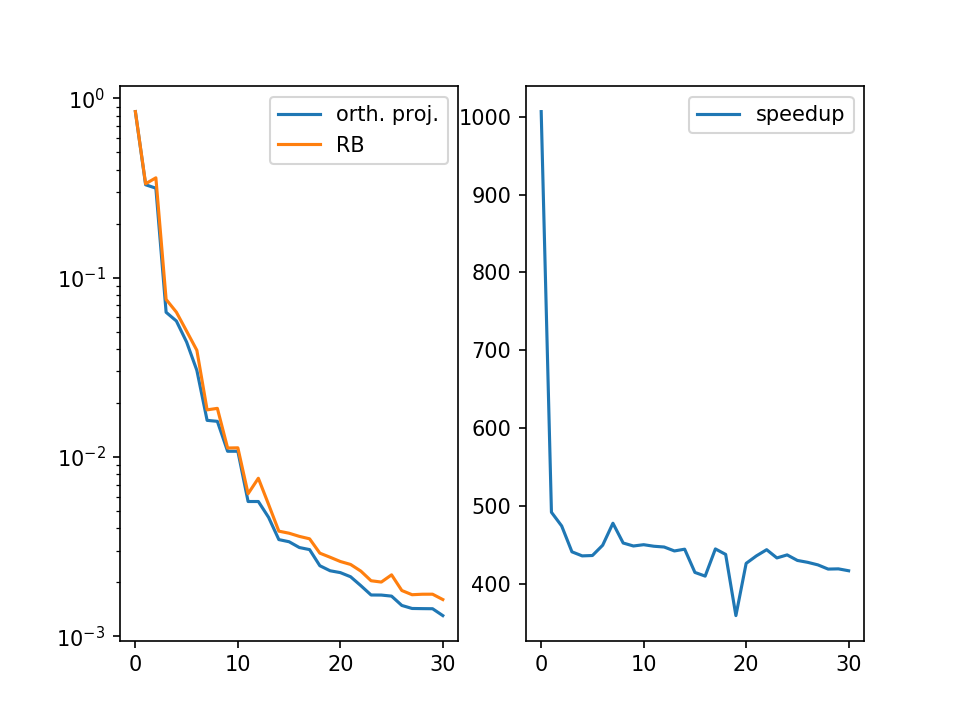

In [17]:
plot_errors(proj_errors, errors, times, d)

Zusätzlich plotten wir die tatsächlichen Kosten wenn man alle offline-Operationen mit einbezieht

<IPython.core.display.Javascript object>


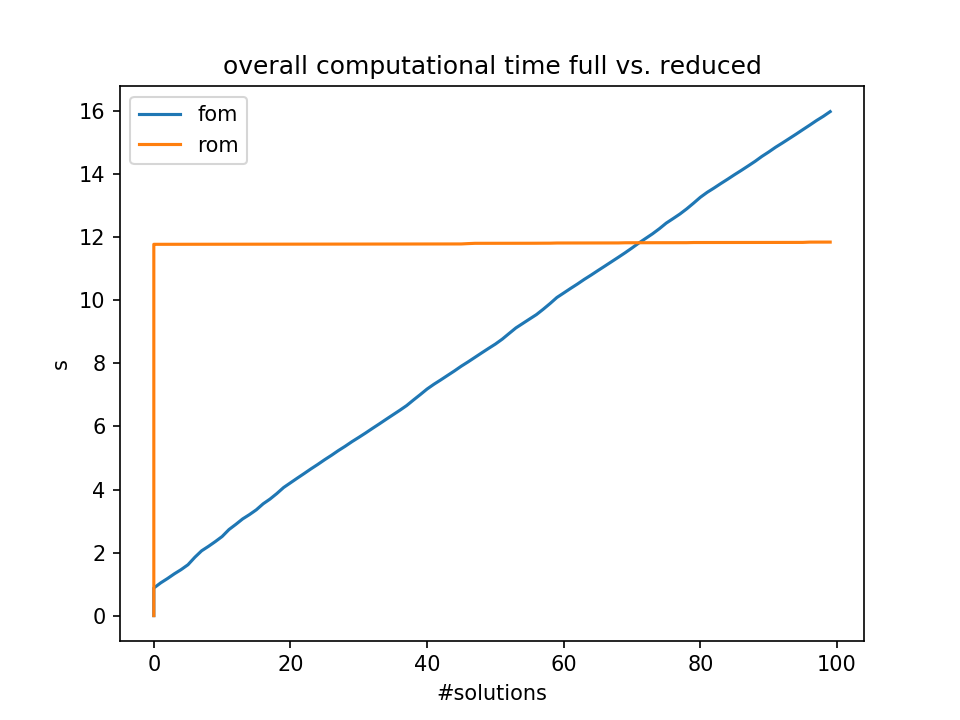

In [18]:
num_solutions = [0, 0]
fom_times = [0, timings['discretize']]
for num, timing in enumerate(timings['fom']):
    num_solutions.append(num)
    fom_times.append(fom_times[-1] + timing)

plt.figure()
plt.plot(num_solutions, fom_times, label='fom')

num_solutions = [0, 0]
rom_times = [0, timings['discretize'] + timings['basis'] + timings['projection']]
for num, mu in enumerate(test_mus):
    num_solutions.append(num)
    t = time.time()
    reduced_op.apply_inverse(reduced_rhs.as_range_array(mu), mu=mu)
    rom_times.append(rom_times[-1] + time.time() - t)

plt.plot(num_solutions, rom_times, label='rom')
plt.xlabel('#solutions')
plt.ylabel('s')
plt.title('overall computational time full vs. reduced')
plt.legend()

2. Wiederholen Sie das selbe Experiment für das parametrische Problem von Blatt 5 Aufabe 2. Was fällt Ihnen auf?

In [19]:
d, _ = discretize_stationary_cg(problem_B5_A2_parametric())
d.enable_caching('disk')

basis = build_basis(d, 30)
test_mus = d.parameter_space.sample_randomly(100, seed=5678)
errors, proj_errors, times = compute_errors(d, basis, test_mus)

.............................................................

03:13 |WARNING|DiffusionOperatorP1: Using inefficient generic projection operator
03:13 |WARNING|BoundaryL2ProductFunctionalP1: Using inefficient generic projection operator


.

03:45 |WARNING|DiffusionOperatorP1: Using inefficient generic projection operator
03:45 |WARNING|BoundaryL2ProductFunctionalP1: Using inefficient generic projection operator


.

03:57 |WARNING|DiffusionOperatorP1: Using inefficient generic projection operator
03:57 |WARNING|BoundaryL2ProductFunctionalP1: Using inefficient generic projection operator


.

04:10 |WARNING|DiffusionOperatorP1: Using inefficient generic projection operator
04:10 |WARNING|BoundaryL2ProductFunctionalP1: Using inefficient generic projection operator


.

04:23 |WARNING|DiffusionOperatorP1: Using inefficient generic projection operator
04:23 |WARNING|BoundaryL2ProductFunctionalP1: Using inefficient generic projection operator


.

04:35 |WARNING|DiffusionOperatorP1: Using inefficient generic projection operator
04:35 |WARNING|BoundaryL2ProductFunctionalP1: Using inefficient generic projection operator


.

04:48 |WARNING|DiffusionOperatorP1: Using inefficient generic projection operator
04:49 |WARNING|BoundaryL2ProductFunctionalP1: Using inefficient generic projection operator


.

05:01 |WARNING|DiffusionOperatorP1: Using inefficient generic projection operator
05:01 |WARNING|BoundaryL2ProductFunctionalP1: Using inefficient generic projection operator


.

05:14 |WARNING|DiffusionOperatorP1: Using inefficient generic projection operator
05:14 |WARNING|BoundaryL2ProductFunctionalP1: Using inefficient generic projection operator


.

05:27 |WARNING|DiffusionOperatorP1: Using inefficient generic projection operator
05:27 |WARNING|BoundaryL2ProductFunctionalP1: Using inefficient generic projection operator


.

05:40 |WARNING|DiffusionOperatorP1: Using inefficient generic projection operator
05:40 |WARNING|BoundaryL2ProductFunctionalP1: Using inefficient generic projection operator


.

05:53 |WARNING|DiffusionOperatorP1: Using inefficient generic projection operator
05:53 |WARNING|BoundaryL2ProductFunctionalP1: Using inefficient generic projection operator


.

06:06 |WARNING|DiffusionOperatorP1: Using inefficient generic projection operator
06:06 |WARNING|BoundaryL2ProductFunctionalP1: Using inefficient generic projection operator


.

06:18 |WARNING|DiffusionOperatorP1: Using inefficient generic projection operator
06:18 |WARNING|BoundaryL2ProductFunctionalP1: Using inefficient generic projection operator


.

06:32 |WARNING|DiffusionOperatorP1: Using inefficient generic projection operator
06:32 |WARNING|BoundaryL2ProductFunctionalP1: Using inefficient generic projection operator


.

06:46 |WARNING|DiffusionOperatorP1: Using inefficient generic projection operator
06:46 |WARNING|BoundaryL2ProductFunctionalP1: Using inefficient generic projection operator


<IPython.core.display.Javascript object>


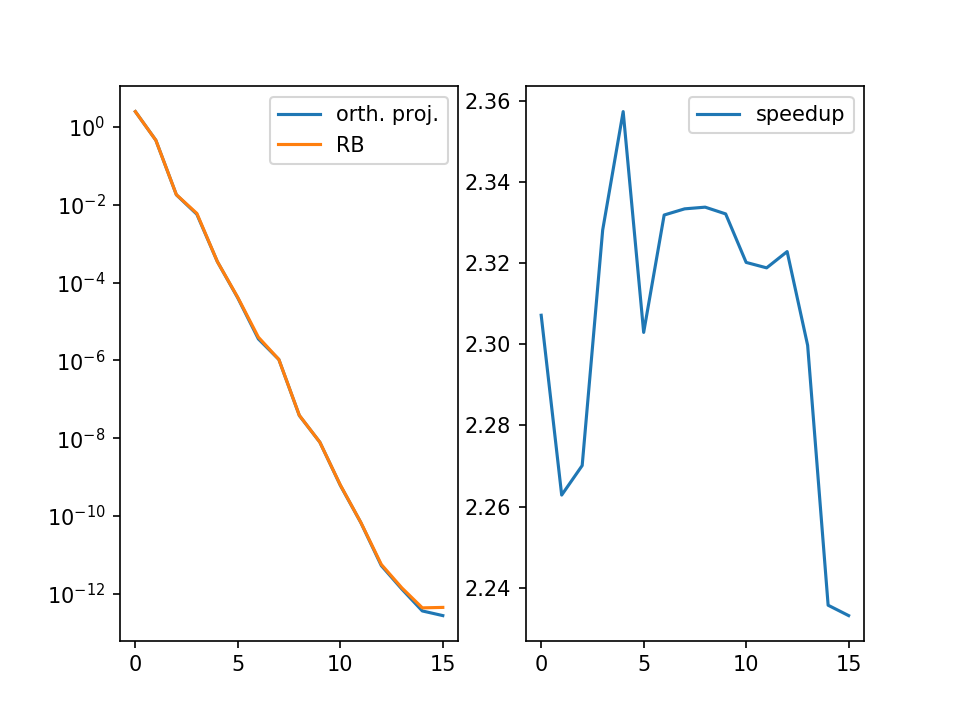

In [20]:
plot_errors(proj_errors, errors, times, d)

Hier ergibt sich aufgrund der fehlenden Offline-Online-Zerlegung nur ein sehr geringer Speedup (rechter Plot). Die von pyMOR ausgegebene Warnung weist darauf hin, dass keine offline-online-zerlegte Projektion des jeweiligen Operators möglich ist und daher ein generischer `ProjectedOperator` angelegt wird, der zwar ein mathematisch korrektes Ergebnis liefert, in `apply` jedoch stets eine Auswertung des ursprünglichen hochdimensionalen Operators benötigt.

3. Passen Sie ihre Definition von Blatt 5 Aufgabe 2 so an, dass die Datenfunktionen nur aus `Lincomb` Operatoren besteht, speichern Sie die Funktion als `problem_B5_A2_parametric_decomb` und wiederholen Sie erneut das Experiment von oben. Was ist hier noch falsch? 

4. Definieren Sie ihre Diskretisierung so, dass auch das `BoundaryL2ProductFunctionalP1` Offline-Online zerlegt werden kann und Wiederholen Sie das Experiment.

## Aufgabe 3: Reduktoren und Fehlerschätzer

Bisher haben wir die RB-Projektionen von `d.operator` und `d.rhs` manuell durchgeführt. Die in pyMOR definierten `Reduktoren` führen RB-Projektionen automatisch für alle in der gegebenen Diskretisierung enthaltenen Operatoren (einschließlich Skalarprodukte und etwaige Ausgabefunktionale) durch und liefern eine diese projizierten Operatoren enthaltende reduzierte Diskretisierung zurück.

Hierfür muss der Reduktor mit der zu reduzierenden Diskretisierungen und einer reduzierten Basis initialisiert werden. Die reduzierte Diskretisierung wird dann von der `reduce`-Methode des Reduktors berechnet. Die hochdimensionale Rekonstruktion eines RB-Lösungsvektors ist mittels der `reconstruct`-Methode möglich. 

1. Vereinfachen Sie den Code aus Aufgabe 2, indem Sie `GenericRBReductor` verwenden, um eine RB-projizierte reduzierte Diskretisierung zu erhalten. Führen Sie das Experiment aus Aufgabe 2 erneut durch. 

2. Verwenden Sie nun `CoerciveRBReductor`, um zusätzlich einen Fehlerschätzer für den Modellreduktionsfehler zu assemblieren. Leiten Sie hierfür zunächst eine geeignete untere Schranke für die Koerzivitätskonstante des jeweils betrachteten Problem her. Wiederholen Sie erneut das Experimant von oben und visualisieren Sie im selben Plot den Fehlerschätzer. Plotten Sie außerden empirisch bestimmte minimale und maximale Effizienz des Fehlerschätzers gegen die Basisgröße.